# Lbl2Vec

The main goal of this notebook is to classify each document into defined topics/classes using the algorithm Lbl2Vec (https://towardsdatascience.com/unsupervised-text-classification-with-lbl2vec-6c5e040354de).

In [48]:
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np

from lbl2vec import Lbl2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import spacy

# -- Data

## Documents

In [2]:
bbc_news_df = pd.read_csv('../../datasets/BBC_News/dataset.csv')
bbc_news_df.head()

,document,class_name,class_index,dataset_type
0,hit shelf combine medium player phone gaming g...,tech,1,train
1,bid hope join host apply host tournament aim r...,sport,4,train
2,lord wrong detainee straw straw attack decisio...,politics,3,train
3,leak answer minister explain budget detail pri...,politics,3,train
4,delight manager pay tribute goal striker beat ...,sport,4,train


In [3]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [4]:
bbc_news_df['tagged_docs'] = bbc_news_df.apply(
    lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)])
    , axis=1)
bbc_news_df['doc_key'] = bbc_news_df.index.astype(str)
bbc_news_df.head()

,document,class_name,class_index,dataset_type,tagged_docs,doc_key
0,hit shelf combine medium player phone gaming g...,tech,1,train,"([hit, shelf, combine, medium, player, phone, ...",0
1,bid hope join host apply host tournament aim r...,sport,4,train,"([bid, hope, join, host, apply, host, tourname...",1
2,lord wrong detainee straw straw attack decisio...,politics,3,train,"([lord, wrong, detainee, straw, straw, attack,...",2
3,leak answer minister explain budget detail pri...,politics,3,train,"([leak, answer, minister, explain, budget, det...",3
4,delight manager pay tribute goal striker beat ...,sport,4,train,"([delight, manager, pay, tribute, goal, strike...",4


## Classes

In [5]:
def get_predefined_keywords(df, k):
    keywords = {}
    classes = df['class_name'].unique()

    for c in classes:
        documents_for_class = df[df['class_name'] == c]

        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(documents_for_class['document'])

        top_k_words = pd.DataFrame(
            data=X.toarray(), columns=vectorizer.get_feature_names_out()
        ).sum().sort_values(ascending=False).head(k).index.tolist()

        keywords[c] = top_k_words
    
    return keywords

In [6]:
N_KEYWORDS = 10
PREDEFINED_KEYWORDS = get_predefined_keywords(bbc_news_df, N_KEYWORDS)

In [7]:
class_df = pd.DataFrame()
class_df['class_index'] = bbc_news_df['class_index'].unique()
class_df['class_name'] = class_df['class_index'].apply(
    lambda class_index: bbc_news_df[bbc_news_df['class_index'] == class_index]['class_name'].unique()[0]
)
class_df['keywords'] = class_df['class_name'].apply(
    lambda class_name: PREDEFINED_KEYWORDS[class_name]
)
class_df['number_of_keywords'] = class_df['keywords'].apply(lambda keywords: len(keywords))
class_df.head()

,class_index,class_name,keywords,number_of_keywords
0,1,tech,"[game, phone, mobile, service, technology, use...",10
1,4,sport,"[win, play, game, player, good, match, team, f...",10
2,3,politics,"[election, party, labour, government, tory, pl...",10
3,2,business,"[company, firm, sale, rise, share, market, gro...",10
4,0,entertainment,"[film, good, award, show, win, music, star, in...",10


# -- Model

In [8]:
lbl2vec_model = Lbl2Vec(
    keywords_list=list(class_df['keywords']), 
    tagged_documents=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'train'], 
    label_names=list(class_df['class_name']),
)
lbl2vec_model.fit()

2023-09-29 10:00:21,052 - Lbl2Vec - INFO - Train document and word embeddings
2023-09-29 10:00:24,858 - Lbl2Vec - INFO - Train label embeddings


# -- Evaluation

In [9]:
train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'test'])

2023-09-29 10:00:24,892 - Lbl2Vec - INFO - Get document embeddings from model
2023-09-29 10:00:24,898 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-09-29 10:00:28,519 - Lbl2Vec - INFO - Calculate document embeddings
2023-09-29 10:00:28,803 - Lbl2Vec - INFO - Calculate document<->label similarities


In [10]:
evaluation_train = train_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
evaluation_test = test_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

y_true_train = evaluation_train['class_name']
y_pred_train = evaluation_train['most_similar_label']

y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']

print(f'F1 score on train set: {f1_score(y_true_train, y_pred_train, average="micro")}')
print(f'F1 score on test set: {f1_score(y_true_test, y_pred_test, average="micro")}')

F1 score on train set: 0.8438202247191011
F1 score on test set: 0.8853932584269663


The model seems to be random and the results change one iteration after another.

Text(0.5, 0.98, 'F1 score by class')

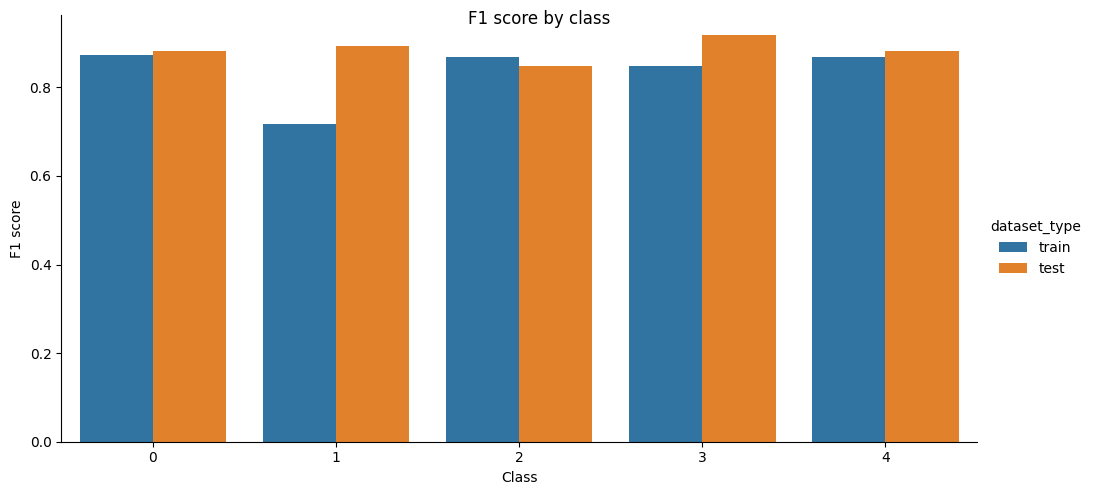

In [11]:
f1_scores_train = f1_score(y_true_train, y_pred_train, average=None)
f1_scores_test = f1_score(y_true_test, y_pred_test, average=None)

f1_scores_df = pd.DataFrame({'train': f1_scores_train, 'test': f1_scores_test})
f1_scores_df['class'] = f1_scores_df.index
f1_scores_df = f1_scores_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

fig = sns.catplot(data=f1_scores_df, x='class', y='f1_score', hue='dataset_type', kind='bar', height=5, aspect=2)
fig.set(xlabel='Class', ylabel='F1 score')
fig.fig.suptitle('F1 score by class')

- We can see that the model perform really well, and the more we add keywords the higher the F1 scores are + train and test are closer.
- There seems to be a limitation on the performance of the model, as the number of keywords becomes higher, the F1 scores decreases.

> **Problem:**
>
> Here we know the keywords for each classes. How to extract keywords in an unsupervised way without knowing the classes ?

# -- Keywords analysis

In [12]:
def train_and_eval(keywords: dict, n_iterations: int = 1):
    """ Train and evaluate the model with the given keyword and number of iterations. 
        The number of iteration can be used to reduce the randomness of the model.
    """
    # Create a dataframe with the most similar label for each document
    class_df = pd.DataFrame()
    class_df['class_index'] = bbc_news_df['class_index'].unique()
    class_df['class_name'] = class_df['class_index'].apply(
        lambda class_index: bbc_news_df[bbc_news_df['class_index'] == class_index]['class_name'].unique()[0]
    )
    class_df['keywords'] = class_df['class_name'].apply(
        lambda class_name: keywords[class_name]
    )
    class_df['number_of_keywords'] = class_df['keywords'].apply(lambda keywords: len(keywords))
    class_df.head()

    f1_train_scores = []
    f1_test_scores = []

    for iter in range(n_iterations):
        lbl2vec_model = Lbl2Vec(
            keywords_list=list(class_df['keywords']), 
            tagged_documents=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'train'], 
            label_names=list(class_df['class_name']),
            min_count=2,
            verbose=False
        )
        lbl2vec_model.fit()

        # Evaluate the model
        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=bbc_news_df['tagged_docs'][bbc_news_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(bbc_news_df[bbc_news_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_name']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_name']
        y_pred_test = evaluation_test['most_similar_label']

        f1_scores_train = f1_score(y_true_train, y_pred_train, average=None)
        f1_scores_test = f1_score(y_true_test, y_pred_test, average=None)

        f1_train_scores.append(f1_scores_train)
        f1_test_scores.append(f1_scores_test)

        print(f'Iteration {iter+1}/{n_iterations} - F1 score on train set: {f1_score(y_true_train, y_pred_train, average="micro")} - F1 score on test set: {f1_score(y_true_test, y_pred_test, average="micro")}')

    f1_train_scores = np.array(f1_train_scores).mean(axis=0)
    f1_test_scores = np.array(f1_test_scores).mean(axis=0)

    f1_scores_df = pd.DataFrame({'train': f1_train_scores, 'test': f1_test_scores})
    f1_scores_df['class'] = f1_scores_df.index
    return f1_scores_df
    

In [52]:
def plot_f1_score(score_df: pd.DataFrame):
    f1_scores_df = score_df.melt(id_vars=['class'], var_name='dataset_type', value_name='f1_score')

    avg_f1_train = f1_scores_df[f1_scores_df['dataset_type'] == 'train']['f1_score'].mean()
    avg_f1_test = f1_scores_df[f1_scores_df['dataset_type'] == 'test']['f1_score'].mean()

    fig = sns.catplot(data=f1_scores_df, x='class', y='f1_score', hue='dataset_type', kind='bar', height=5, aspect=2)
    fig.set(xlabel='Class', ylabel='F1 score')
    fig.fig.suptitle(f'Average F1 score by class (train: {round(avg_f1_train, 6)}, test: {round(avg_f1_test, 6)})', fontweight='bold', fontsize=16)
    fig.tight_layout()

Iteration 1/5 - F1 score on train set: 0.9129213483146068 - F1 score on test set: 0.903370786516854
Iteration 2/5 - F1 score on train set: 0.9101123595505618 - F1 score on test set: 0.9101123595505618
Iteration 3/5 - F1 score on train set: 0.8994382022471911 - F1 score on test set: 0.903370786516854
Iteration 4/5 - F1 score on train set: 0.8904494382022472 - F1 score on test set: 0.9078651685393259
Iteration 5/5 - F1 score on train set: 0.9089887640449438 - F1 score on test set: 0.9213483146067416


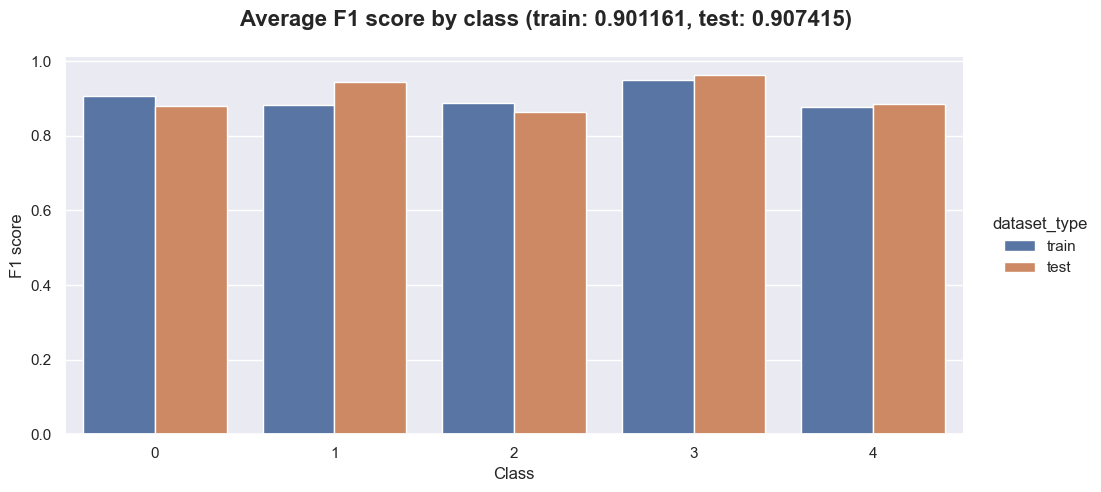

In [53]:
score_df = train_and_eval(PREDEFINED_KEYWORDS, n_iterations=5)
plot_f1_score(score_df)

The supposition that the model is random does not seems to be problematic on the predefined keywords.

In [54]:
classes_name = list(bbc_news_df['class_name'].unique())

In [59]:
def get_all_similar_keywords_by_class(classes_name):
    spacy_similarity_model = spacy.load('en_core_web_lg')
    resulting_keywords = {}

    all_documents_words = []
    for doc in bbc_news_df['document']:
        all_documents_words.extend(doc.split(' '))
    all_documents_words = list(set(all_documents_words))

    for class_name in classes_name:
        print(f'[INFO] Processing class: {class_name}...')

        similarity_levels = []
        
        for word in all_documents_words:
            spacy_word_1 = spacy_similarity_model(word)
            spacy_word_2 = spacy_similarity_model(class_name)

            if(not (spacy_word_1 and spacy_word_1.vector_norm and spacy_word_2 and spacy_word_2.vector_norm)):
                continue
            similarity_level = spacy_word_1.similarity(spacy_word_2)

            similarity_levels.append((word, similarity_level))

        similarity_levels = sorted(similarity_levels, key=lambda x: x[1], reverse=True)
        resulting_keywords[class_name] = [word for word, _ in similarity_levels]
        
    return resulting_keywords

ALL_SIMILAR_KEYWORDS_BY_CLASS = get_all_similar_keywords_by_class(classes_name)

[INFO] Processing class: tech...
[INFO] Processing class: sport...
[INFO] Processing class: politics...
[INFO] Processing class: business...
[INFO] Processing class: entertainment...


In [60]:
def get_k_most_similar_keyword(k):
    resulting_keywords = {}
    for class_name, keywords in ALL_SIMILAR_KEYWORDS_BY_CLASS.items():
        resulting_keywords[class_name] = keywords[:k]
    return resulting_keywords

In [61]:
most_similar_keywords = get_k_most_similar_keyword(2)
most_similar_keywords

{'tech': ['tech', 'technology'],
 'sport': ['sport', 'tennis'],
 'politics': ['political', 'democracy'],
 'business': ['business', 'corporate'],
 'entertainment': ['entertainment', 'television']}

Iteration 1/10 - F1 score on train set: 0.7269662921348314 - F1 score on test set: 0.6831460674157304
Iteration 2/10 - F1 score on train set: 0.9028089887640449 - F1 score on test set: 0.9011235955056179
Iteration 3/10 - F1 score on train set: 0.8646067415730337 - F1 score on test set: 0.8764044943820225
Iteration 4/10 - F1 score on train set: 0.8612359550561798 - F1 score on test set: 0.8719101123595505
Iteration 5/10 - F1 score on train set: 0.8853932584269663 - F1 score on test set: 0.8898876404494382
Iteration 6/10 - F1 score on train set: 0.8719101123595505 - F1 score on test set: 0.8561797752808988
Iteration 7/10 - F1 score on train set: 0.8735955056179776 - F1 score on test set: 0.8831460674157303
Iteration 8/10 - F1 score on train set: 0.8303370786516853 - F1 score on test set: 0.8382022471910112
Iteration 9/10 - F1 score on train set: 0.7219101123595506 - F1 score on test set: 0.6943820224719102
Iteration 10/10 - F1 score on train set: 0.7314606741573035 - F1 score on test set

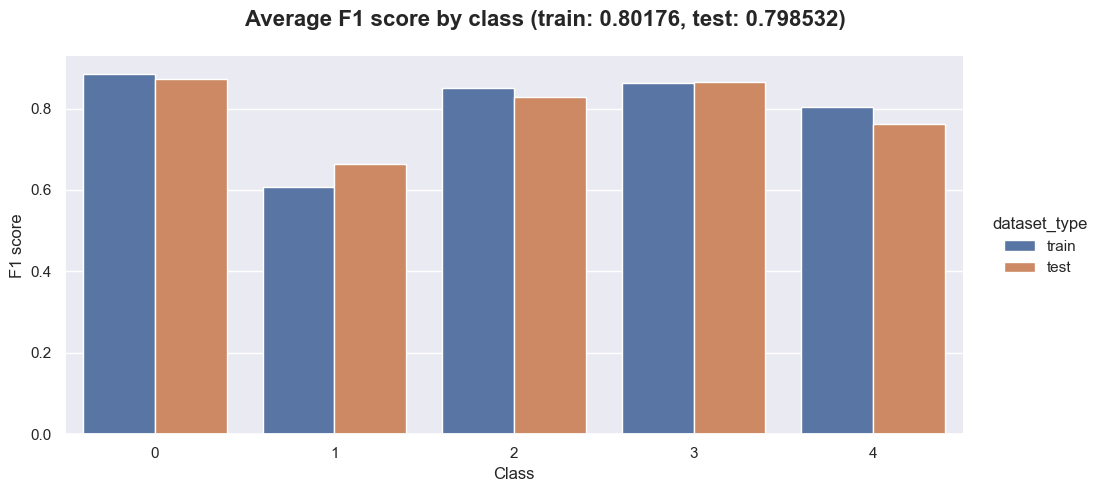

In [62]:
score_df = train_and_eval(most_similar_keywords, n_iterations=10)
plot_f1_score(score_df)

> **Question:**
>
> Why the model is now random ?

### Impact of the number of keywords on the f1 scores

In [76]:
def test_impact_number_keywords(n_list_keywords: list):
    f1_scores = []
    keywords_predefined = get_predefined_keywords(bbc_news_df[bbc_news_df['dataset_type'] == 'train'], max(n_list_keywords))

    for n_keywords in n_list_keywords:
        similarity_most_similar_keywords = get_k_most_similar_keyword(n_keywords)
        predefined_most_similar_keywords = {class_name: keywords[:n_keywords] for class_name, keywords in keywords_predefined.items()}

        similarity_score_df = train_and_eval(similarity_most_similar_keywords, n_iterations=5)
        predefined_score_df = train_and_eval(predefined_most_similar_keywords, n_iterations=5)

        similarity_avg_f1_train = similarity_score_df['train'].mean()
        similarity_avg_f1_test = similarity_score_df['test'].mean()

        predefined_avg_f1_train = predefined_score_df['train'].mean()
        predefined_avg_f1_test = predefined_score_df['test'].mean()

        f1_scores.append((n_keywords, similarity_avg_f1_train, similarity_avg_f1_test, predefined_avg_f1_train, predefined_avg_f1_test))

    f1_scores_df = pd.DataFrame(f1_scores, columns=['n_keywords', 'similarity_avg_f1_train', 'similarity_avg_f1_test', 'predefined_avg_f1_train', 'predefined_avg_f1_test'])
    return f1_scores_df

In [90]:
f1_scores_df = test_impact_number_keywords([1, 2, 5, 10, 15, 20, 30, 50, 80, 100])
f1_scores_df

Iteration 1/5 - F1 score on train set: 0.7286516853932584 - F1 score on test set: 0.7078651685393259
Iteration 2/5 - F1 score on train set: 0.6865168539325842 - F1 score on test set: 0.7123595505617978
Iteration 3/5 - F1 score on train set: 0.7443820224719101 - F1 score on test set: 0.6921348314606741
Iteration 4/5 - F1 score on train set: 0.7235955056179774 - F1 score on test set: 0.6853932584269663
Iteration 5/5 - F1 score on train set: 0.7179775280898877 - F1 score on test set: 0.7056179775280899
Iteration 1/5 - F1 score on train set: 0.6696629213483146 - F1 score on test set: 0.7033707865168539
Iteration 2/5 - F1 score on train set: 0.5921348314606741 - F1 score on test set: 0.6449438202247191
Iteration 3/5 - F1 score on train set: 0.701123595505618 - F1 score on test set: 0.701123595505618
Iteration 4/5 - F1 score on train set: 0.8646067415730337 - F1 score on test set: 0.8764044943820225
Iteration 5/5 - F1 score on train set: 0.797752808988764 - F1 score on test set: 0.8269662921

,n_keywords,similarity_avg_f1_train,similarity_avg_f1_test,predefined_avg_f1_train,predefined_avg_f1_test
0,1,0.671021,0.673410,0.712981,0.741262
1,2,0.797263,0.819152,0.885629,0.897396
2,5,0.768638,0.766411,0.853636,0.866956
3,10,0.803122,0.798881,0.908713,0.909462
4,15,0.885302,0.902123,0.900742,0.912824
5,20,0.881313,0.893344,0.904226,0.914551
6,30,0.868167,0.864285,0.901739,0.903154
7,50,0.850214,0.868179,0.902653,0.914580
8,80,0.827956,0.828587,0.910039,0.919381
9,100,0.852193,0.861328,0.898062,0.903654


In [91]:
def plot_f1_scores_based_number_keywords(f1_scores_df):
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.lineplot(data=f1_scores_df, x='n_keywords', y='predefined_avg_f1_train', label='Predefined - Train', ax=ax, color='blue')
    sns.lineplot(data=f1_scores_df, x='n_keywords', y='predefined_avg_f1_test', label='Predefined - Test', ax=ax, color='blue', linestyle='--')
    
    sns.lineplot(data=f1_scores_df, x='n_keywords', y='similarity_avg_f1_train', label='Similarity - Train', ax=ax, color='green')
    sns.lineplot(data=f1_scores_df, x='n_keywords', y='similarity_avg_f1_test', label='Similarity - Test', ax=ax, color='green', linestyle='--')
    
    ax.set_xlabel('Number of keywords')
    ax.set_ylabel('Average F1 score')
    ax.set_title('Average F1 score based on the number of keywords', fontweight='bold', fontsize=16)
    ax.legend()

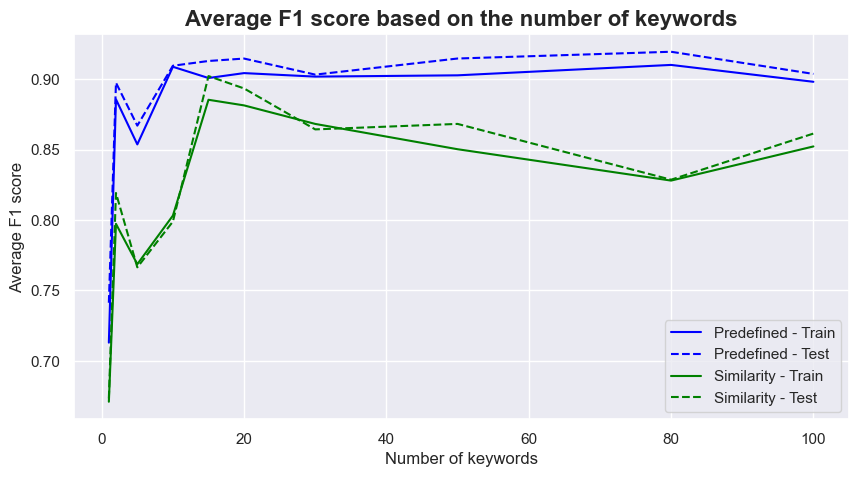

In [92]:
plot_f1_scores_based_number_keywords(f1_scores_df)

In [93]:
focused_f1_scores_df = test_impact_number_keywords([10, 12, 14, 16, 18, 20, 22, 24])
focused_f1_scores_df

Iteration 1/5 - F1 score on train set: 0.8775280898876404 - F1 score on test set: 0.8674157303370787
Iteration 2/5 - F1 score on train set: 0.9134831460674158 - F1 score on test set: 0.9146067415730337
Iteration 3/5 - F1 score on train set: 0.8275280898876405 - F1 score on test set: 0.8089887640449437
Iteration 4/5 - F1 score on train set: 0.7797752808988764 - F1 score on test set: 0.755056179775281
Iteration 5/5 - F1 score on train set: 0.8915730337078651 - F1 score on test set: 0.898876404494382
Iteration 1/5 - F1 score on train set: 0.9157303370786517 - F1 score on test set: 0.9146067415730337
Iteration 2/5 - F1 score on train set: 0.9185393258426966 - F1 score on test set: 0.9213483146067416
Iteration 3/5 - F1 score on train set: 0.8938202247191012 - F1 score on test set: 0.9191011235955057
Iteration 4/5 - F1 score on train set: 0.8758426966292135 - F1 score on test set: 0.8898876404494382
Iteration 5/5 - F1 score on train set: 0.8994382022471911 - F1 score on test set: 0.916853932

,n_keywords,similarity_avg_f1_train,similarity_avg_f1_test,predefined_avg_f1_train,predefined_avg_f1_test
0,10,0.843922,0.837777,0.897661,0.911329
1,12,0.833502,0.839593,0.901471,0.909477
2,14,0.894145,0.897723,0.908870,0.917893
3,16,0.886212,0.896319,0.904927,0.913821
4,18,0.888200,0.885222,0.900934,0.918205
5,20,0.887539,0.892975,0.907651,0.913231
6,22,0.897369,0.904825,0.888998,0.908180
7,24,0.887147,0.883074,0.903712,0.918199


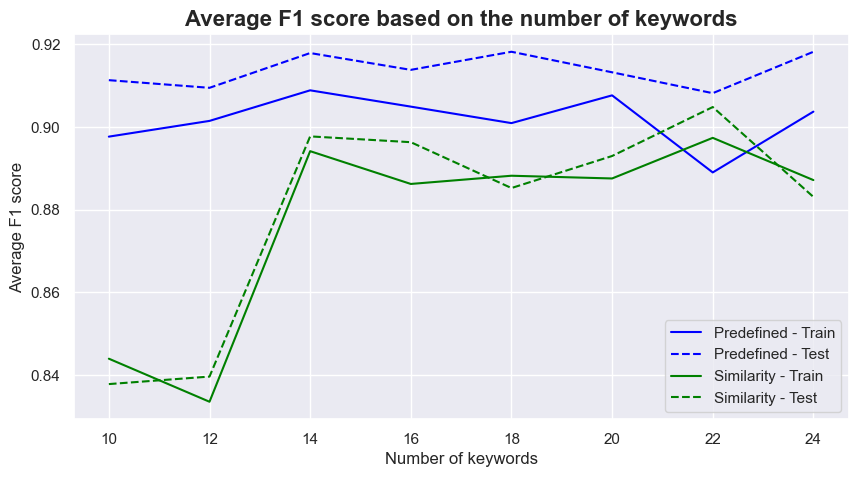

In [94]:
plot_f1_scores_based_number_keywords(focused_f1_scores_df)

# -- Other dataset and Lbl2TransformerVec

In [95]:
def get_dataset(name: str):
    df = pd.read_csv(f'../../datasets/{name}/dataset.csv')

    df['tagged_docs'] = df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)])
        , axis=1)
    df['doc_key'] = bbc_news_df.index.astype(str)

    class_df = pd.DataFrame()
    class_df['class_index'] = df['class_index'].unique()
    class_df['class_name'] = class_df['class_index'].apply(
        lambda class_index: df[df['class_index'] == class_index]['class_name'].unique()[0]
    )
    keywords = get_all_similar_keywords_by_class(list(class_df['class_name'].unique()))
    class_df['keywords'] = class_df['class_name'].apply(
        lambda class_name: keywords[class_name]
    )
    class_df['number_of_keywords'] = class_df['keywords'].apply(lambda keywords: len(keywords))
    
    return df

In [ ]:
def test_models_on_dataset(dataset_df: pd.DataFrame, class_df: pd.DataFrame, n_iterations: int = 1):
    lbl2vec_model = Lbl2Vec(
        keywords_list=list(class_df['keywords']), 
        tagged_documents=dataset_df['tagged_docs'][dataset_df['dataset_type'] == 'train'], 
        label_names=list(class_df['class_name']),
    )
    lbl2vec_model.fit()